### Hierarchical classification training demo
Based on my previous work.
TODO: Switch to Guillaume's

In [1]:
import glob
import json
import os
import random
from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.parse import urljoin
from urllib.request import urlretrieve

import numpy as np
import torch
from hierarchical.utils import create_hierarchy, mask_hierarchy
from hierarchical.loss import MultiLevelCrossEntropyLoss
from torch import nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm.contrib.concurrent import thread_map
from tqdm.notebook import tqdm as TQDM

from mini_trainer.classifier import get_model
from mini_trainer.utils import ImageClassLoader

In [2]:
repo = "https://anon.erda.au.dk/share_redirect/btK3WIh4Md/rebalanced75_without_larvae/"

with NamedTemporaryFile(suffix = "txt") as tmpfile:
    urlretrieve(
        urljoin(repo, "folder_index.txt"),
        tmpfile.name
    )
    with open(tmpfile.name, "r") as f:
        file_index = [line.strip() for line in f.readlines()]

### Extract the class hierarchy from the directory structure

In [3]:
hierarchy = sorted(filter(lambda x : len(x) == 3, set(tuple(path.split("/")[:-1]) for path in TQDM(file_index, desc="Finding unique classes..."))))

Finding unique classes...:   0%|          | 0/1405516 [00:00<?, ?it/s]

Count the number of images per class (species)

In [4]:
counts = defaultdict(lambda : 0)

for path in TQDM(file_index, desc="Counting images per class..."):
    path_from_root = tuple(path.split("/")[:-1])
    if path_from_root in hierarchy:
        counts[path_from_root] += 1

Counting images per class...:   0%|          | 0/1405516 [00:00<?, ?it/s]

Filter species with less than 1000 images, and select 200 training images and 25 test images

In [5]:
more_than_1000 = set(cls for cls in hierarchy if counts[cls] >= 3000)
print(f'Number of classes with more than 1000 images: {len(more_than_1000)}')
print(f'Number of total images for selected classes: {sum(counts[cls] for cls in more_than_1000)}')
train_counts, test_counts = defaultdict(lambda : 0), defaultdict(lambda : 0)
train_images, test_images = [], []
for path in TQDM(file_index, desc="Allocating train/test images..."):
    path_from_root = tuple(path.split("/")[:-1])
    if not (path_from_root in more_than_1000):
        continue
    if train_counts[path_from_root] < 200:
        train_counts[path_from_root] += 1
        train_images.append(path)
    elif test_counts[path_from_root] < 25:
        test_counts[path_from_root] += 1
        test_images.append(path)
print(f'Number of training images: {len(train_images)}')
print(f'Number of test images: {len(test_images)}')

Number of classes with more than 1000 images: 172
Number of total images for selected classes: 735486


Allocating train/test images...:   0%|          | 0/1405516 [00:00<?, ?it/s]

Number of training images: 34400
Number of test images: 4300


### Download train/test images

In [6]:
train_dir = os.path.join("hierarchical", "train")
test_dir = os.path.join("hierarchical", "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def _download_one(f, d, override=False):
    lpath = os.path.join(d, f)
    if os.path.exists(lpath):
        if override:
            os.remove(lpath)
        else:
            return
    os.makedirs(os.path.dirname(lpath), exist_ok=True)
    urlretrieve(
        urljoin(repo, f),
        lpath
    )

thread_map(lambda x : _download_one(x, test_dir), test_images, tqdm_class=TQDM, desc="Downloading test images...")
thread_map(lambda x : _download_one(x, train_dir), train_images, tqdm_class=TQDM, desc="Downloading train images...")
pass

### Define custom hierarchical architecture

In [7]:
class HierarchicalClassifier(nn.Module):
    def __init__(self, in_features : int, out_features : int, masks : Optional[List[torch.Tensor]]=None, hidden : bool=False):
        super().__init__()
        # Create a BatchNormalization Layer
        self.batch_norm = nn.BatchNorm1d(in_features)

        # Create one hidden layer
        self.hidden = hidden and nn.Linear(in_features, in_features)

        # Create a standard linear layer.
        self.linear = nn.Linear(in_features, out_features, bias=True)

        # Store masks
        self.masks = [m.T.clone(memory_format=torch.contiguous_format) for m in masks] or []
        [m.requires_grad_(False) for m in self.masks]
        
        # Set the bias to -1 and freeze it.
        with torch.no_grad():
            self.linear.bias.fill_(-1)
        self.linear.bias.requires_grad_(False)

    def forward(self, x):
        if self.hidden:
            x = nn.functional.leaky_relu(self.hidden(x), True)
        x = self.batch_norm(x)
        # Compute the normalized log probabilities for the leaf nodes (level 0)
        y0 = nn.functional.log_softmax(self.linear(x), dim = 1)
        ys = [y0]
        # Propagate the probabilities up the hierarchy using the masks
        for mask in self.masks:
            ys.append(nn.functional.log_softmax(torch.logsumexp(ys[-1].unsqueeze(2) + mask, dim = 1), dim=1))
        return ys
    
    @staticmethod
    def load(model_type : str, path : str, masks : Optional[List[torch.Tensor]]=None, device=torch.device("cpu"), dtype=torch.float32):
        # Parse model architecture
        architecture, head_name, _ = get_model(model_type)

        # Read weight file
        weights = torch.load(path, device, weights_only=True)
        if isinstance(weights, dict) and "model" in weights:
            weights = weights["model"]
        num_classes, num_embeddings = weights[f"{head_name}.linear.weight"].shape
        
        # Load weights into model architecture
        setattr(architecture, head_name, HierarchicalClassifier(num_embeddings, num_classes, [m.to(device, dtype) for m in masks]))
        architecture.load_state_dict(weights)
        architecture.to(device, dtype)
        
        return architecture
    
def hierarchical_model_builder(
        model : str,
        masks : List[torch.Tensor],
        weights : Optional[str],
        fine_tune : bool,
        device : torch.device,
        dtype : torch.dtype,
        num_classes : int,
        **kwargs : Any
    ) -> Tuple[nn.Module, Callable[[torch.Tensor], torch.Tensor]]:
    if len(kwargs) != 0:
        unexpected = ", ".join(kwargs.keys())
        raise TypeError(f"my_fun() got unexpected keyword argument(s): {unexpected}")
    model, head_name, model_preprocess = get_model(model)
    model : nn.Module
    if not isinstance(model, nn.Module):
        raise TypeError(f"Unknown model type `{type(model)}`, expected `{nn.Module}`")
    head = getattr(model, head_name)
    num_embeddings = (head[1] if not isinstance(head, nn.Linear) else head).in_features
    if weights is not None:
        model = HierarchicalClassifier.load(
            model_type=model, 
            path=weights, 
            masks=[m.to(device, torch.float32) for m in masks], 
            device=device, 
            dtype=torch.float32
        )
    else:
        classifier = HierarchicalClassifier(
            in_features=num_embeddings, 
            out_features=num_classes, 
            masks=[m.to(device, torch.float32) for m in masks]
        )
        setattr(model, head_name, classifier)
        model.to(device, torch.float32)
    if fine_tune:
        for name, param in model.named_parameters():
            if param.requires_grad and not head_name in name:
                param.requires_grad_(False)
    return model, model_preprocess

### Define utilities for overriding the default class handling behaviour in mini_trainer

In [8]:
def hierarchical_parse_class_index(path : Optional[str]=None, dir : Optional[str]=None):
    """
    Accepts a path to a class index file or a directory with named subdirectories for each class.
    """
    if path is None or not os.path.exists(path):
        if dir is None or not os.path.isdir(dir):
            raise TypeError(f'If `path` is not the path to a valid file, `dir` must be a valid directory, not \'{dir}\'.')
        combinations = sorted(set(tuple(f.split(os.sep)[:-1]) for f in glob.glob("**", root_dir=dir, recursive=True) if not os.path.isdir(os.path.join(dir, f))))
        classes = {i : [] for i in range(len(next(iter(combinations))))}
        for e in combinations:
            for lvl, cls in enumerate(e):
                if cls not in classes[lvl]:
                    classes[lvl].append(cls)
        classes = {lvl : classes[lvl] for lvl in range(len(classes))}
        cls2idx = {lvl : {cls : idx for idx, cls in enumerate(classes[lvl])} for lvl in range(len(classes))}
        if path is not None:
            with open(path, "w") as f:
                json.dump({"cls2idx" : cls2idx, "combinations" : combinations}, f)
    else:
        with open(path, "rb") as f:
            c2i_comb = json.load(f)
            cls2idx = {int(lvl) : e for lvl, e in c2i_comb["cls2idx"].items()}
            combinations = c2i_comb["combinations"]
    cls = [list(cls2idx[lvl]) for lvl in range(len(cls2idx))]
    idx2cls = {lvl : {v : k for k, v in cls2idx[lvl].items()} for lvl in range(len(cls2idx))}
    ncls = [len(clvl) for clvl in cls]
    hierarchy = create_hierarchy(combinations, cls2idx)
    masks = mask_hierarchy(hierarchy, zero=-100)
    return {"num_classes" : ncls[-1], "masks" : list(reversed(masks))}, {"classes" : cls, "class2idx" : cls2idx, "idx2class" : idx2cls}

In [ ]:
def multi_level_collate(batch):
    return tuple(torch.stack(v) for v in zip(*batch))

def hierarchical_dataloader_builder(
        data_index : str,
        input_dir : str,
        classes : List[str],
        class2idx : Dict[str, int],
        preprocess : Callable[[torch.Tensor], torch.Tensor],
        batch_size : int,
        device : torch.device,
        dtype = torch.dtype,
        resize_size : Optional[int]=None,
        train_proportion : float=0.9,
        idx2class : Optional[Dict[int, str]]=None,
        num_workers : Optional[int]=None
    ):
    # Prepare datasets/dataloaders
    if data_index is None:
        all_files = [path for f in glob.glob("**", root_dir=input_dir, recursive=True) if not os.path.isdir(path := os.path.join(input_dir, f))]
        data = {
            "path" : [],
            "class" : [],
            "split" : []
        }
        for path in all_files:
            data["path"].append(path)
            data["class"].append([class2idx[lvl][cls] for lvl, cls in enumerate(os.path.relpath(path, input_dir).split(os.sep)[:-1])])
            data["split"].append("train" if random.random() < train_proportion else "validation")
        data = {k : np.array(v) for k, v in data.items()}
        train_image_data = {k : v[data["split"] == np.array("train")] for k, v in data.items()}
        val_image_data = {k : v[data["split"] == np.array("validation")] for k, v in data.items()}
        
    resize_size = preprocess.resize_size if hasattr(preprocess, "resize_size") else resize_size

    if not isinstance(resize_size, int):
        if not (isinstance(resize_size, tuple) and len(resize_size) == 2 and all(map(lambda x : isinstance(x, int), resize_size))):
            raise TypeError(f'Invalid resize size passed, foun {resize_size}, but expected an integer or a tuple of two integers')
    print(f"Building datasets with image size {resize_size}")

    def path2cls2idx(path, cls2idx=class2idx, nlvl=len(class2idx)):
        return torch.tensor(list(reversed([cls2idx[lvl][cls] for lvl, cls in enumerate(path.split(os.sep)[:-1][-nlvl:])]))).long()#.to(device)

    loader = ImageClassLoader(path2cls2idx, resize_size=resize_size, preprocessor=lambda x : x, dtype=dtype, device=torch.device("cpu"))
    train_dataset = loader(train_image_data["path"])
    val_dataset = loader(val_image_data["path"])

    train_sampler = RandomSampler(train_dataset)
    val_sampler = SequentialSampler(val_dataset)

    if num_workers is None:
        num_workers = os.cpu_count() - 1
        num_workers -= num_workers % 2

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        collate_fn=multi_level_collate,
        num_workers=num_workers,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        sampler=val_sampler, 
        collate_fn=multi_level_collate,
        num_workers=num_workers, 
        pin_memory=True
    )

    return train_loader, val_loader


In [ ]:
import importlib
import mini_trainer.trainer
importlib.reload(mini_trainer.trainer)
# importlib.reload(mini_trainer.utils)
# importlib.reload(mini_trainer.classifier)
# importlib.reload(mini_trainer.builders)
# importlib.reload(mini_trainer.train)
from mini_trainer.train import main

torch.cuda.empty_cache()
main(
    input="hierarchical/train",
    output="hierarchical",
    model="efficientnet_v2_s",
    # weights="hierarchical/efficientnet_b0_full_e2.pt",
    batch_size=16,
    learning_rate=0.001,
    warmup_epochs=0.1,
    epochs=10,
    dtype="float16",
    spec_model_dataloader=hierarchical_parse_class_index,
    dataloader_builder=hierarchical_dataloader_builder,
    dataloader_builder_kwargs={"resize_size": 256, "train_proportion": 0.9},
    model_builder=hierarchical_model_builder,
    criterion_builder=MultiLevelCrossEntropyLoss,
    criterion_kwargs={"label_smoothing" : 0.01, "weights" : [0.1, 0.25, 0.65]}
)

Building datasets with image size 256
Start training


Test:  Acc@1 87.553 Acc@5 96.988


Test:  Acc@1 92.867 Acc@5 98.380
Training time 0:03:36


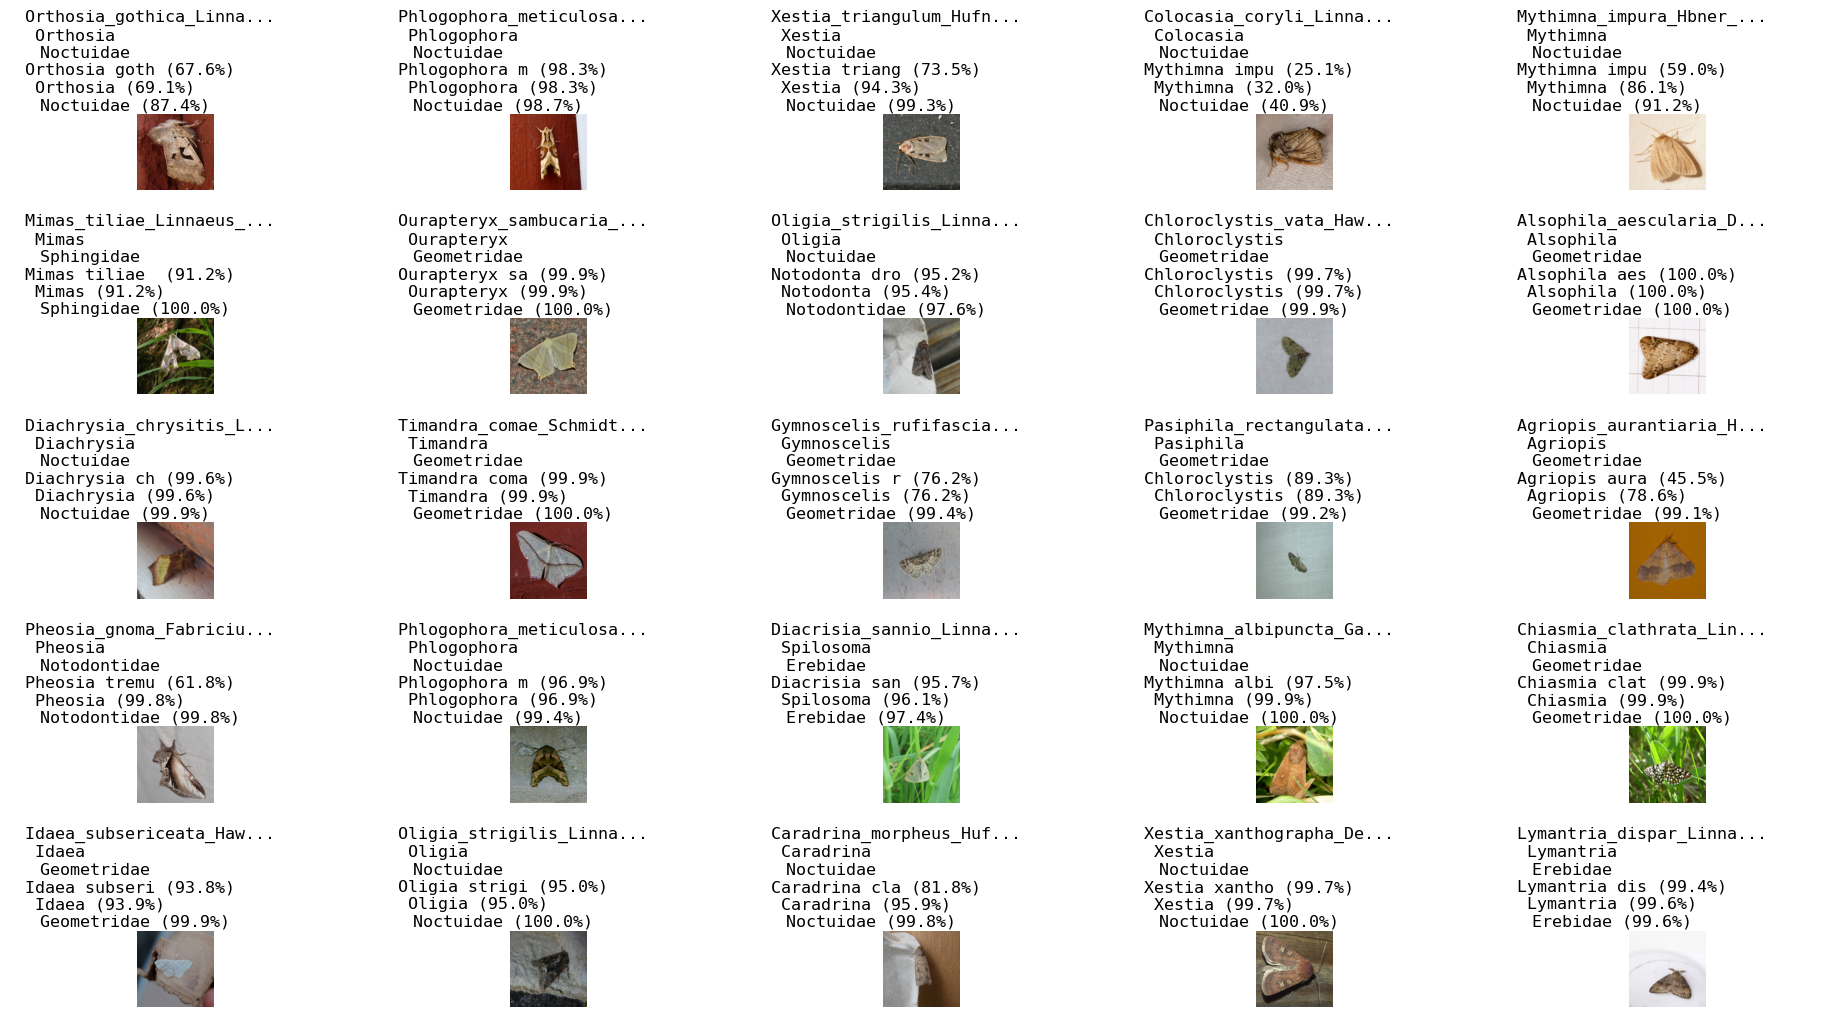

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

import random

from mini_trainer.predict import ImageLoader
from mini_trainer.utils import BaseResultCollector

device, dtype = torch.device("cuda:0"), torch.float32

class_info = hierarchical_parse_class_index("hierarchical/class_index.json")
cls2idx, idx2cls = class_info[1]["class2idx"], class_info[1]["idx2class"]
model, mproc = hierarchical_model_builder(
    model = "efficientnet_b0",
    weights = "hierarchical/efficientnet_v2_s_full_e10.pt",
    fine_tune = False,
    device = device,
    dtype = dtype,
    **class_info[0]
)
model.eval()

images = random.sample(test_images, 25)
ds = ImageLoader(lambda x : x, dtype, device)([os.path.join(test_dir, f) for f in images])

# label_fmt = ",".join(["{:>" + str(ml) + "}" for ml in [3, 3, 2]])
label_fmt = "{:<30}\n  {:<30}\n   {:<30}"
def reformat_title(s : str, max_col : int=25):
    lines = s.split("\n")
    return "\n".join([line[:(max_col-3)] + "...     " if len(line.strip()) >= max_col else line for line in lines])

fig, axs = plt.subplots(5, 5, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    tim = ds[i]
    with torch.no_grad():
        prediction = model(mproc(tim).unsqueeze(0))
    if not isinstance(ax, Axes):
        raise TypeError()
    ax.imshow(tim.permute(1, 2, 0).cpu().clamp(0, 1))
    # pstr = label_fmt.format(*[str(lcls.argmax().item()) for lcls in prediction])
    # lstr = label_fmt.format(*reversed([str(cls2idx[lvl][cls]) for lvl, cls in enumerate(images[i].split(os.sep)[:-1])]))
    pstr = label_fmt.format(*[f'{idx2cls[lvl][lcls.argmax().item()].replace("_", " ")[:13]} ({lcls.max().exp().item():.1%})' for lvl, lcls in zip(reversed(range(3)), prediction)])
    lstr = label_fmt.format(*reversed(images[i].split(os.sep)[:-1]))
    pttl = reformat_title(f'{lstr}\n{pstr}')
    ax.set_title(pttl, pad=0, y=1.05, fontdict={"family" : "monospace"})
    ax.axis("off")

plt.tight_layout(pad=0, h_pad=1.5)
plt.savefig("predictions25.png")
plt.close()

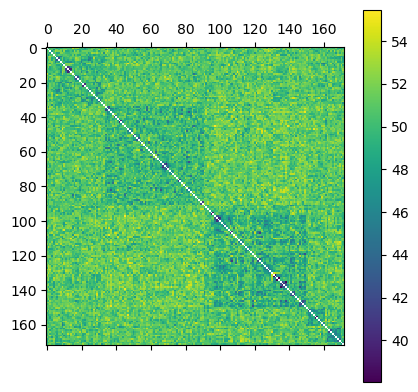

In [ ]:
llw = model.classifier.linear._parameters["weight"].data

llw -= llw.mean(dim = 1, keepdim=True)
llw /= llw.std(dim = 1, unbiased=True, keepdim=True)
# llw = llw.norm(2, dim=1)

cos_mat = (llw @ llw.T) #/ (llw.unsqueeze(0) * llw.unsqueeze(1))
eucl_mat = torch.cdist(llw, llw)

plt.matshow(eucl_mat.cpu().fill_diagonal_(torch.nan))
plt.colorbar()
plt.savefig("weight_cor.png")
plt.close()